# Node Label Prediction \ Link Prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import networkx as nx
%matplotlib inline

We will start by node label prediction. Download [this](https://www.dropbox.com/s/sta1krsbnnp7ju0/ppi.CC.gml?dl=0) network. It contains protein communications in Baker’s yeast. Each node (protein) has a special binary attribute *ICSC (intracellular signaling cascade)*.

In [37]:
g = nx.read_gml('ppi.CC.gml')
cc = list(nx.connected_components(g))
g = nx.subgraph(g,cc[0])
g = nx.relabel.convert_node_labels_to_integers(g)

In [61]:
labels = np.array(nx.get_node_attributes(g, 'ICSC').values(), dtype=float)

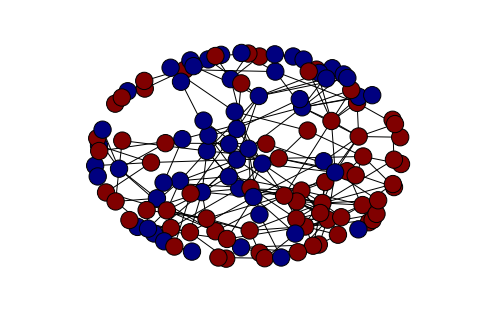

In [25]:
nx.draw_spring(g, node_color = labels)

It might not be clear from the picture above but the level of homogeneity is quite high. For each node we are able to compute the average value of label

(array([  5.,   1.,   3.,  15.,  12.,  34.]),
 array([ 0.        ,  0.16666667,  0.33333333,  0.5       ,  0.66666667,
         0.83333333,  1.        ]),
 <a list of 6 Patch objects>)

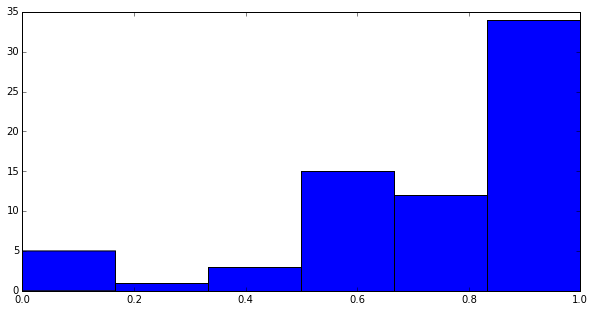

In [42]:
nnICSC = np.asarray(map(lambda(v): np.mean(labels[g.neighbors(v)]), g.nodes_iter()))
nnICSC
plt.figure(figsize=(10,5))
plt.hist(nnICSC[np.where(labels == 1)], bins=6,)

## Iterative Classification Method

ICM is kind of NN-classifier. Our prediction is based on the largest ratio of nearest neighbours of unlabeled nodes.

#### Task 1

* Randomly set unlabeled nodes. 
* Implement classification rule of ICM (HINT look at the code cell above)
* Implement function for classification error and use it wisely

In [45]:
lablNN = labels[:]
idx = np.random.randint(0,len(lablNN), size=40)
lablNN[idx] = np.nan

In [46]:
idx = np.nonzero(np.isnan(lablNN))[0]
lablClassified = np.asarray(map(lambda(v): np.round(np.nanmean(lablNN[g.neighbors(v)])), idx))
lablNN[idx] = lablClassified

In [49]:
def classError(trueLabel, predictLabel):
    return np.sum(trueLabel != predictLabel)

In [50]:
classError(labels, lablNN)

2

## Label Propagation

Now instead of looking at neigbours we are switching random walks between all the nodes

Just to recall the Label Propagation method:
1. Compute $P = D^{-1}A$
2. Set $Y^{(0)} = (Y_l,0)$ ($Y_l$ - labeled data)
3. **repeat**
    * $Y^{(t+1)} = PY^{(t)}$
    * $Y_l^{(t+1)} = Y_l$
4. **until** $Y^{(t)}$ converges

In [62]:
# It is better to initialize like that
fixedLabels = labels[:]+1
curLabels = labels[:]+1

# And indicate labeled nodes instead of unlabeled
idxLabeled = np.zeros((g.number_of_nodes(),), dtype=bool)
idxLabeled[np.random.randint(0,len(labels), size=90)] = True
curLabels[~idxLabeled] = 0

In [56]:
def LabelPropagation(G, idxLabeled, curLabels, fixedLabels, iters = 1000):
    A = np.asarray(nx.adj_matrix(G).todense())
    P = np.diag(1.0/sum(A)).dot(A)
    
    iterNorm = 1.0
    resultLabels = P.dot(curLabels)
    deltaNorm = 1.0
    iterNum = 1
    
    while (deltaNorm > 1e-2 and iterNum < iters and ~np.all(resultLabels >= 1)):
        iterNorm = np.linalg.norm(resultLabels - curLabels)
        runLabels, curLabels = resultLabels[:],resultLabels[:]
        runLabels[idxLabeled] = fixedLabels[idxLabeled]
        resultLabels = P.dot(runLabels)
        deltaNorm = np.abs(iterNorm - np.linalg.norm(resultLabels - curLabels))
        print deltaNorm
        iterNum+=1
    print 'Converged in {0} iteration'.format(iterNum)
    return np.round(resultLabels)

In [64]:
LabelPropagation(g, idxLabeled, curLabels, fixedLabels, iters = 20)

5.56124137939
0.966722081427
0.492843014641
0.238272078167
0.146452514602
0.0794148206923
0.0536833993737
0.0312276365292
0.0227875768108
0.0140418262942
0.0108463056012
0.00703095793244
Converged in 13 iteration


array([ 2.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,
        1.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  1.,  2.,  2.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,
        2.,  1.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,
        1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  2.,  1.,
        1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  1.,
        1.,  1.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  2.,  2.,
        1.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,
        1.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,  1.,  1.,
        2.,  1.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.])

## Link Prediction - Scoring functions

In this section we will implement some scoring functions for link prediction and compare the values for adjacent and non-adjacent nodes.

Load [french blog network](https://www.dropbox.com/s/rn0y18a511vfx1t/fblog.gml?dl=0) and compute the following scores:

In [77]:
g = nx.read_gml('fblog.gml')
vNum = g.number_of_nodes()

In [78]:
def matrixPlot(A):
    plt.figure(1, figsize=(6, 6))
    plt.imshow(A,
           interpolation="none"
           )

#### Shortest Path Length

In [79]:
# Your code here
shPaths = nx.shortest_paths.floyd_warshall_numpy(g)

#### Number of common neighbours

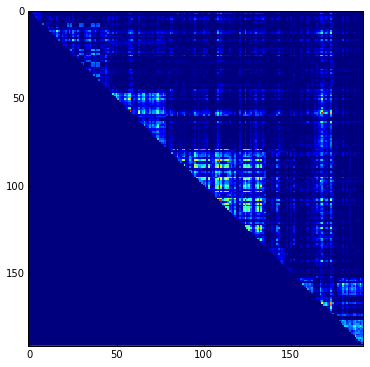

In [80]:
comNeigh = np.zeros((vNum,vNum))
# Your code here
for i in xrange(vNum):
    for j in xrange(i+1, vNum):
        comNeigh[i,j] = len(list(nx.common_neighbors(g, i, j)))

matrixPlot(comNeigh)

#### Jaccard Score

In [82]:
jacScore = np.zeros((vNum,vNum))
# Your code here
for i in xrange(vNum):
    for j in xrange(i+1, vNum):
        jacScore[i,j] =1.0*len(list(nx.common_neighbors(g, i, j)))/len(np.union1d(nx.neighbors(g,i),nx.neighbors(g,j)))

#### Adamic/Adar Score

$Score(a,b) = \sum\limits_{v \in \text{NN}(a) \cap \text{NN}(b)} \frac{1}{|\text{NN}(v)|}$

In [83]:
# Adamic/Adar 
# Your code here
scoreAd = np.zeros((vNum,vNum))
for i in xrange(vNum):
    for j in xrange(i+1, vNum):
        for v in nx.common_neighbors(g, i, j):
            scoreAd[i,j]+=1.0/len(nx.neighbors(g,v))

#### Preferential Attachment score

$Score(a,b) = |\text{NN}(a)| \times |\text{NN}(b)|$

In [ ]:
# Your code here
prefScore = np.zeros((vNum,vNum))
for i in xrange(vNum):
    for j in xrange(i+1, vNum):
        prefScore[i,j] = len(nx.neighbors(g,i)) * len(nx.neighbors(g,j))

#### Katz Score

$Score(a,b) = \sum\limits_{\text{Paths}_{x,y}} \beta^{|p_{a,b}|}\times|p_{a,b}|$

In [85]:
# Your code here
katzScore = np.zeros((vNum, vNum))
beta = 0.6
for i in xrange(vNum):
    for j in xrange(i+1, vNum):
        l = map(lambda x: beta**len(x)*len(x), tuple(nx.all_simple_paths(g, i, j, cutoff=4)))
        katzScore[i,j] = np.sum(np.power(beta, l)*l)

KeyboardInterrupt: 

Let's compare the scores behavious for pairs of nodes with or without edge in-between

In [19]:
A = np.asarray(nx.adj_matrix(g).todense())
xyTriu = np.vstack(np.triu_indices_from(A, k=1)).T
wEdge = [katzScore[xy[0],xy[1]] for xy in xyTriu if A[xy[0],xy[1]]]
woEdge = [katzScore[xy[0],xy[1]] for xy in xyTriu if ~A[xy[0],xy[1]]]
data = [wEdge, woEdge]

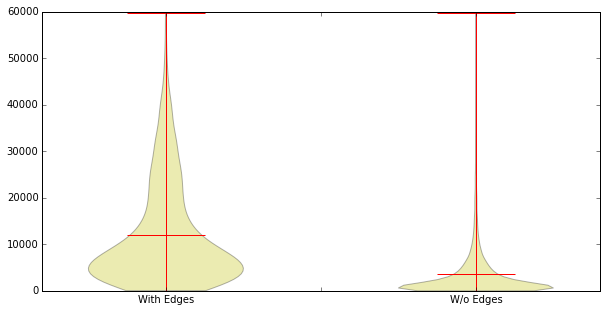

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
axes.violinplot(data, showmeans=True)
axes.set_xticklabels(['', 'With Edges', '', 'W/o Edges'])